In [21]:
import allel
import plotly.express as px
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

ModuleNotFoundError: No module named 'anjl'

In [25]:
!pip3 install anjl

ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python <3.13,>=3.10; 0.2.0 Requires-Python <3.13,>=3.10; 0.3.0 Requires-Python <3.13,>=3.10; 0.4.0 Requires-Python <3.13,>=3.10; 0.5.0 Requires-Python <3.13,>=3.10; 0.6.0 Requires-Python <3.13,>=3.10; 0.7.0 Requires-Python <3.13,>=3.10; 0.8.0 Requires-Python <3.13,>=3.10; 0.9.0 Requires-Python <3.13,>=3.10; 1.0.0 Requires-Python <3.13,>=3.10; 1.0.1 Requires-Python <3.13,>=3.10; 1.1.0 Requires-Python <3.13,>=3.10; 1.1.1 Requires-Python <3.13,>=3.10; 1.1.2 Requires-Python <3.13,>=3.10; 1.1.3 Requires-Python <3.13,>=3.10; 1.2.0 Requires-Python <3.13,>=3.10; 1.2.1 Requires-Python <3.13,>=3.10; 1.3.0 Requires-Python <3.13,>=3.10; 1.4.0 Requires-Python <3.13,>=3.10
ERROR: Could not find a version that satisfies the requirement anjl (from versions: none)
ERROR: No matching distribution found for anjl


In [5]:
# Define useful bits and pieces
zarr_path = '/scratch/user/uqtdenni/staged_zarr/{contig}.zarr'

# Get all contigs in the genome
ref_path = "/scratch/user/uqtdenni/reference/reference/VectorBase-54_AfarautiFAR1_Genome.fasta"

# Get contig lengths
contig_lengths = {}
for record in SeqIO.parse(ref_path, "fasta"):
    seq_id = record.id
    seq_length = len(record.seq)
    contig_lengths[seq_id] = seq_length

# Sort by length and get top 5
filtered_contigs = {k: v for k, v in sorted(contig_lengths.items(), key=lambda item: item[1], reverse=True) if v > 100000}
analysis_contigs = list(filtered_contigs.keys())

In [6]:
x = analysis_contigs[0]
x

'KI915040'

In [7]:
ds = xr.open_zarr(zarr_path.format(contig='KI915040'))


In [8]:
def load_metadata():
    dfs = []
    for sample_set in sample_sets:
        d = pd.read_csv(metadata_url.format(sample_set = sample_set))
        dfs.append(d)
    return pd.concat(dfs)

# Get genotypes from the longest contig, subset to samples passing QC and passing filters
def load_gt(contig, indices_keep=None):
    ds = xr.open_zarr(zarr_path.format(contig=contig))
    gt_raw = allel.GenotypeArray(ds['call_genotype'])
    gt_raw = gt_raw.compress(ds['filter_pass'][:], axis=0)
    if indices_keep is None:
        return gt_raw
    else: 
        return gt_raw.compress(indices_keep, axis=1)

def return_n_alt(gt_block, n_snps=50_000):
    ac = gt_block.count_alleles()
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gt_block.compress(flt, axis=0)
    gn = gf.to_n_alt()
    vidx = np.random.choice(gn.shape[0], n_snps, replace=False)
    vidx.sort()
    gnr = gn.take(vidx, axis=0)
    return gnr

def plot_pca(coords, model, x, y, colourfactor, df):

    # Assumed df aligns along exis with PCA
    pca_df = pd.concat([pd.DataFrame(coords), df], axis=1)
    
    fig = px.scatter(pca_df, 
               x=x, 
               y=y, 
               color=colourfactor, 
               width =600,
               height=500,
               hover_data = ['country','admin1_iso','vcf_id'],
              template = 'simple_white')
    
    fig.update_traces(marker=dict(size=10, opacity=0.5))

    fig.update_layout(xaxis_title=f"PC{x+1} ({model.explained_variance_ratio_[x]*100:.2f}%)", yaxis_title=f"PC{y+1} ({model.explained_variance_ratio_[y]*100:.2f}%)")

    fig.show()


def run_pca(contig, indices_keep, n_snps=50_000):
    # Load GTS
    gts = load_gt(contig, indices_keep = samples_keep)
    n_a = return_n_alt(gts, n_snps=n_snps) # calculate n_ alt from biallelic sites with a mac > 1
    coords, model = allel.pca(n_a, n_components=10, scaler='patterson') # calculate PCA
    return coords, model

In [9]:
# Load metadata (incomplete atm)
df_samples = pd.read_table('/scratch/user/uqtdenni/metadata/derived_sample_metadat_draft.txt')

# Samples to keep
#ex_samples = ['far_WPSI_sol_25','far_WPSI_sol_24', 'far_WPSI_sol_31', 'far_WPSI_sol_33','far_nNG_LR-176BO1','far_nNG_LR-176BO3','far_nNG_LR-176BO2','far_nNG_LR-176BO4','far_nNG_LR-176G14','far_nNG_LR-176G17','far_nNG_LR-88-G6','far_nNG_LR-88G5','f4-MP126-6','far8_98_89_28','far_nNG_f1', 'far_nNG_f1-LR109-1', 'far_nNG_f1-LR109-2','far_nNG_SR-93-92-2', 'far_nNG_SR-93-92-13','far_nNG_SR-93-92-12','far_nNG_SR-93-92-11','far_nNG_MP-94-4', 'far_nNG_MP-94-2']
ex_samples = ['f4-MP126-6','far8_98_89_28','far_nNG_f1']
samples_keep = np.array(~df_samples.vcf_id.isin(ex_samples))
df_samples = df_samples[samples_keep]

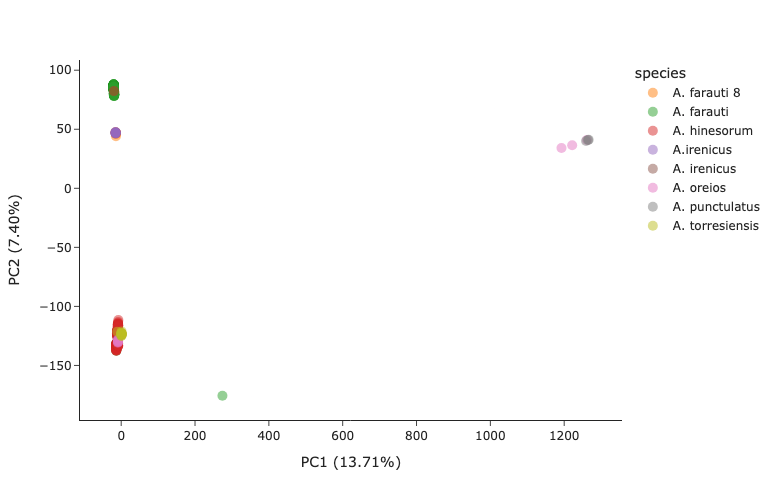

CPU times: user 1min 12s, sys: 9.64 s, total: 1min 22s
Wall time: 1min 5s


In [10]:
%%time
all_coords,  all_model = run_pca(analysis_contigs[0], samples_keep)
plot_pca(all_coords, all_model, 0, 1, 'species', df_samples)

The outgroup sample there (I think) represents a an admixed PNG / SI population - whenever I remove it, it is replaced by another sample.
Let's dig a little into these clusters - will start by doing per-country PCA?

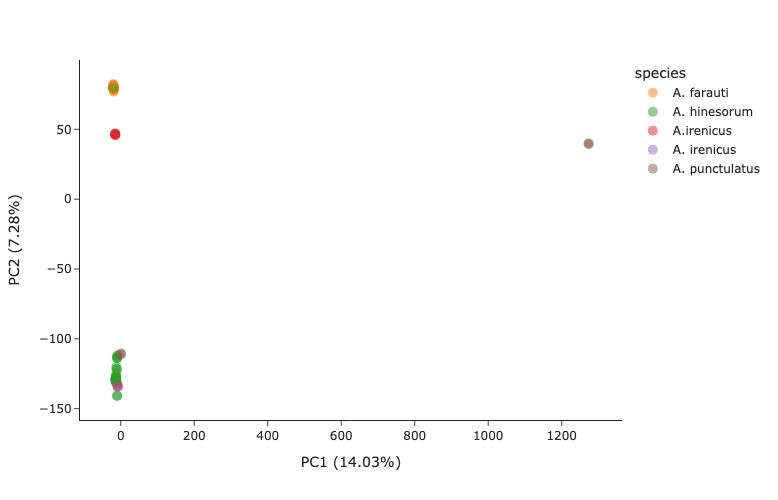

In [20]:
si_sample_df = df_samples[df_samples.country == 'Solomon Islands']
#si_coords,  si_model = run_pca(analysis_contigs[0], si_sample_df.vcf_id)
plot_pca(si_coords, si_model, 0, 1, 'species', si_sample_df)